# Calculating total energy in $Z^0 \to b \bar{b}$ events and determining the thrust

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import random
from scipy.optimize import minimize

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_types = {"ccbar": ["cc","$Z^0 \\to c \\bar{c}$"],
              "bbbar": ["bb","$Z^0 \\to b \\bar{b}$"],
              "qqbar": ["qq","$Z^0 \\to q \\bar{q}$"],
              "mumu": ["mumu","$Z^0 \\to \\mu^+ \\mu^-$"],
              "ee": ["ee","$Z^0 \\to e^+ e^-$"]
             }

#Choose the event type
file_type = "bbbar"

file = uproot.open(f"/eos/experiment/fcc/ee/tmp/ee_Z_{file_type}_EDM4Hep.root")
tree = file['events']

Load the reconstructed particles:

In [2]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

r = tree.arrays(keep_vars,how="zip")[:999]
r[r_c,'p'] = kinematics.calc_p(r,r_c)

Calculate the total energy in each event, summed over all reco particles (`axis=1` sums over the particles):

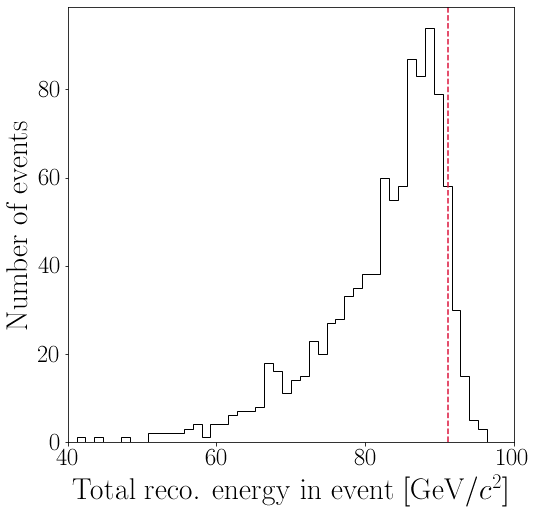

In [3]:
E = ak.sum(r[r_c,'energy'],axis=1)

fig, ax = plt.subplots(figsize=(8,8))
low = 40
high = 100
plt.hist(E.tolist(),bins=50, histtype='step', color='k', range=(low,high))
plt.axvline(x=lp.Z_0.mass/1000.,color='crimson',linestyle='--')
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("Total reco. energy in event [GeV/$c^2$]",fontsize=30)
plt.ylabel("Number of events",fontsize=30)
plt.show()

Calculate the maximum thrust $T = \frac{\Sigma_i | \vec{p}_i \cdot \hat{n} |}{\Sigma_i | \vec{p}_i|}$ of events by running a `scipy` minimiser. The maximum thrust corresponds to a specific thrust axis (given by unit vector $\hat{n}$) where the longitundinal momentum sum is highest. To determine the best axis, we iterate over possible directions of $\hat{n}$ in `scipy`, and pick the unit vector which minimises $-T$ (i.e. maximises $T$).

For two-jet events, $T$ is close to 1, while a spherically symmetric event has $T = \frac{1}{2}$.

In [4]:
#Calculate the thrust for a given set of thrust axis components
def thrust(pars):
    #Magnitude of the thrust axis vector to make a unit vector
    mag = np.sqrt(pars[0]**2 + pars[1]**2 + pars[2]**2)
                    
    #Numerator of the thrust expression
    T_num = ak.sum(abs(event[r_c,'momentum.x']*(pars[0]/mag) + event[r_c,'momentum.y']*(pars[1]/mag) + event[r_c,'momentum.z']*(pars[2]/mag)))
                    
    #Denominator of the thrust expression
    T_den = ak.sum(abs(event[r_c,'p']))
                    
    #Thrust
    t_val = T_num / T_den
    
    #Return minus so that scipy minimises -T i.e. maximises T
    return -t_val

#Maximum thrust values found for each event
T = np.empty(len(r), np.float64)

#Thrust axis components, where this axis is the one corresponding to maximim thrust
T_axis = {"x": np.empty(len(r), np.float64),
          "y": np.empty(len(r), np.float64),
          "z": np.empty(len(r), np.float64)
         }

#Loop over events and minimise -T, in order to find the best thrust axis
n = 0
for event in r:
    if(n % 100 ==0):
        print(f"Processing event {n}")
        
    #Thrust axis components initial values
    pars = [1., 1., 1.]
    
    #Use scipy minimiser to detemrine the thrust axis components which give the highest thrust
    res = minimize(thrust, pars, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
    
    #Optimised thrust axis components (res.x contains the fit results from scipy)
    T_axis["x"][n] = res.x[0]
    T_axis["y"][n] = res.x[1]
    T_axis["z"][n] = res.x[2]
    
    #Maximised value of the thrust
    T[n] = -res.fun
    
    n += 1

#Store the values
r['thrust'] = T
for comp in ["x","y","z"]:
    r[f'thrust_axis_{comp}'] = T_axis[comp]

Processing event 0
Processing event 100
Processing event 200
Processing event 300
Processing event 400
Processing event 500
Processing event 600
Processing event 700
Processing event 800
Processing event 900


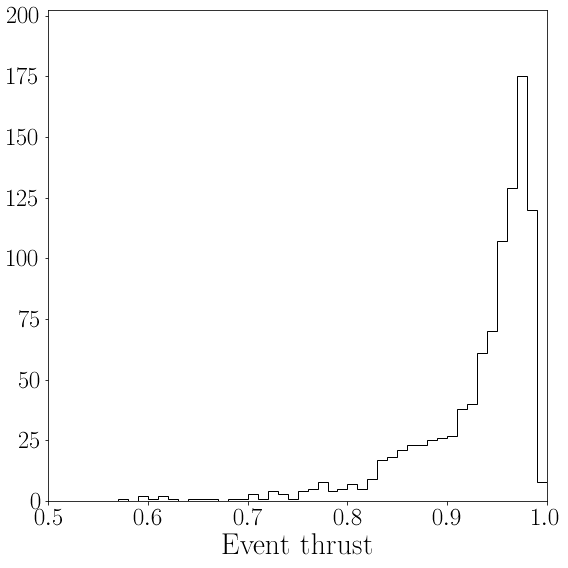

In [5]:
plotting.hist_plot(r['thrust'],f'event_thrust_{file_type}',"Event thrust",0.5,1.0,50)

Persist the thrust parameters to a JSON file for use in other notebooks:

In [6]:
thrust_dict = {}
for i in range(0,len(r)):
    thrust_dict[i] = {}
    thrust_dict[i]["thrust"] = T[i]
    for comp in ["x","y","z"]:
        thrust_dict[i][f"thrust_axis_{comp}"] = T_axis[comp][i]

with open(f"{loc.JSON}/thrust_{file_type}.json", 'w') as fp:
    json.dump(thrust_dict, fp)

Calculate the angle between each particle and the thrust axis:

In [7]:
r['thrust_axis_mag'] = np.sqrt(r['thrust_axis_x']**2 + r['thrust_axis_y']**2 + r['thrust_axis_z']**2)
r[r_c,'costheta_thrust'] = (r[r_c,'momentum.x']*r['thrust_axis_x'] + r[r_c,'momentum.y']*r['thrust_axis_y'] + r[r_c,'momentum.z']*r['thrust_axis_z']) / (abs(r[r_c,'p']) * abs(r['thrust_axis_mag']))  

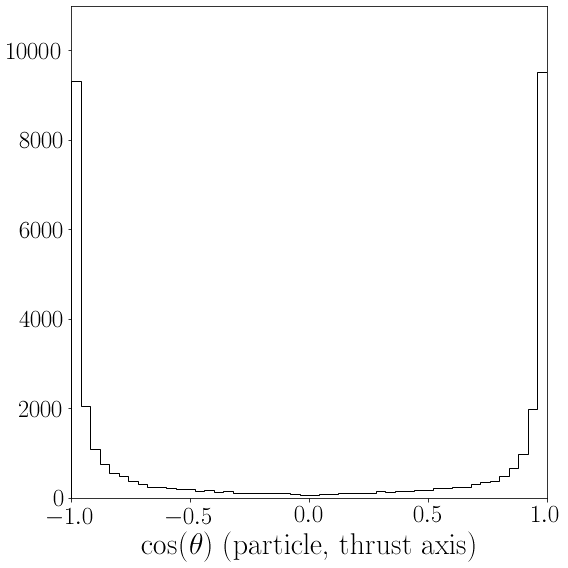

In [8]:
plotting.hist_plot(ak.flatten(r[r_c,'costheta_thrust']),f'costheta_thrust_{file_type}',"$\\cos(\\theta)$ (particle, thrust axis)",-1.,1.,50)

We can use the angle relative to the thrust axis to determine which hemisphere (i.e. which $b$-quark) a particle belongs to. Splitting the data either side of $\cos(\theta) = 0$ selects the two hemispheres:

In [9]:
r_1 = r[r_c][r[r_c,'costheta_thrust'] >= 0]
r_2 = r[r_c][r[r_c,'costheta_thrust'] < 0]

Let's plot the energy in the two hemispheres, and then also the energy difference. Events with a large energy difference are consistent with high missing energy, characteristic of a semileptonic decay:

In [10]:
E_1 = ak.sum(r_1['energy'],axis=1)
E_2 = ak.sum(r_2['energy'],axis=1)
E_diff = E_1 - E_2

Energy in the two hemispheres:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


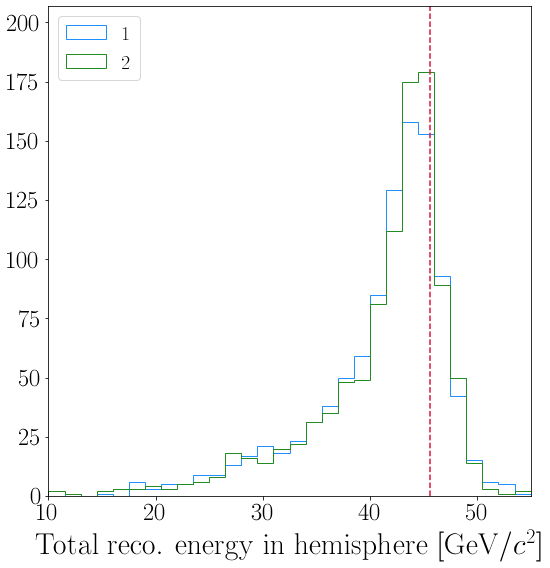

In [11]:
bins = 30
low = 10.
high = 55.
fig, ax = plt.subplots(figsize=(8,8))
plt.hist(E_1,bins=bins,range=(low,high),histtype='step',color='dodgerblue',label='1')
plt.hist(E_2,bins=bins,range=(low,high),histtype='step',color='forestgreen',label='2')
plt.axvline(x=0.5*lp.Z_0.mass/1000.,color='crimson',linestyle='--')
plt.xlabel("Total reco. energy in hemisphere [GeV/$c^2$]",fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
ymin, ymax = plt.ylim()
plt.ylim(0.,ymax*1.1)
plt.legend(fontsize=20, loc='upper left')
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/hemisphere_energy_{file_type}.pdf")

Difference in energy between the two hemispheres:

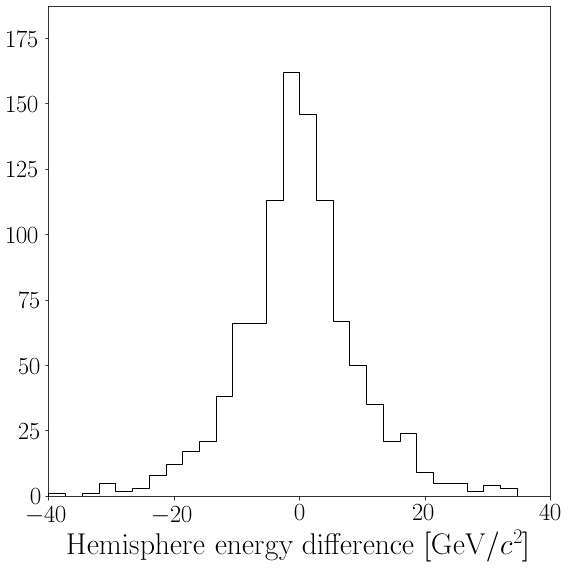

In [12]:
bins = 30
low = -40.
high = 40.
fig, ax = plt.subplots(figsize=(8,8))
plt.hist(E_diff,bins=bins,range=(low,high),histtype='step',color='k')
plt.xlabel("Hemisphere energy difference [GeV/$c^2$]",fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
ymin, ymax = plt.ylim()
plt.ylim(0.,ymax*1.1)
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/hemisphere_energy_diff_{file_type}.pdf")